In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.misc import imresize
import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict
from sklearn.model_selection import train_test_split
%matplotlib inline

In [20]:
# split data into train and test according to train.txt and test.txt
if not os.path.isdir('food101/test') and not os.path.isdir('food101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food101/images', 'food101/test', ignore=ignore_train)
    copytree('food101/images', 'food101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


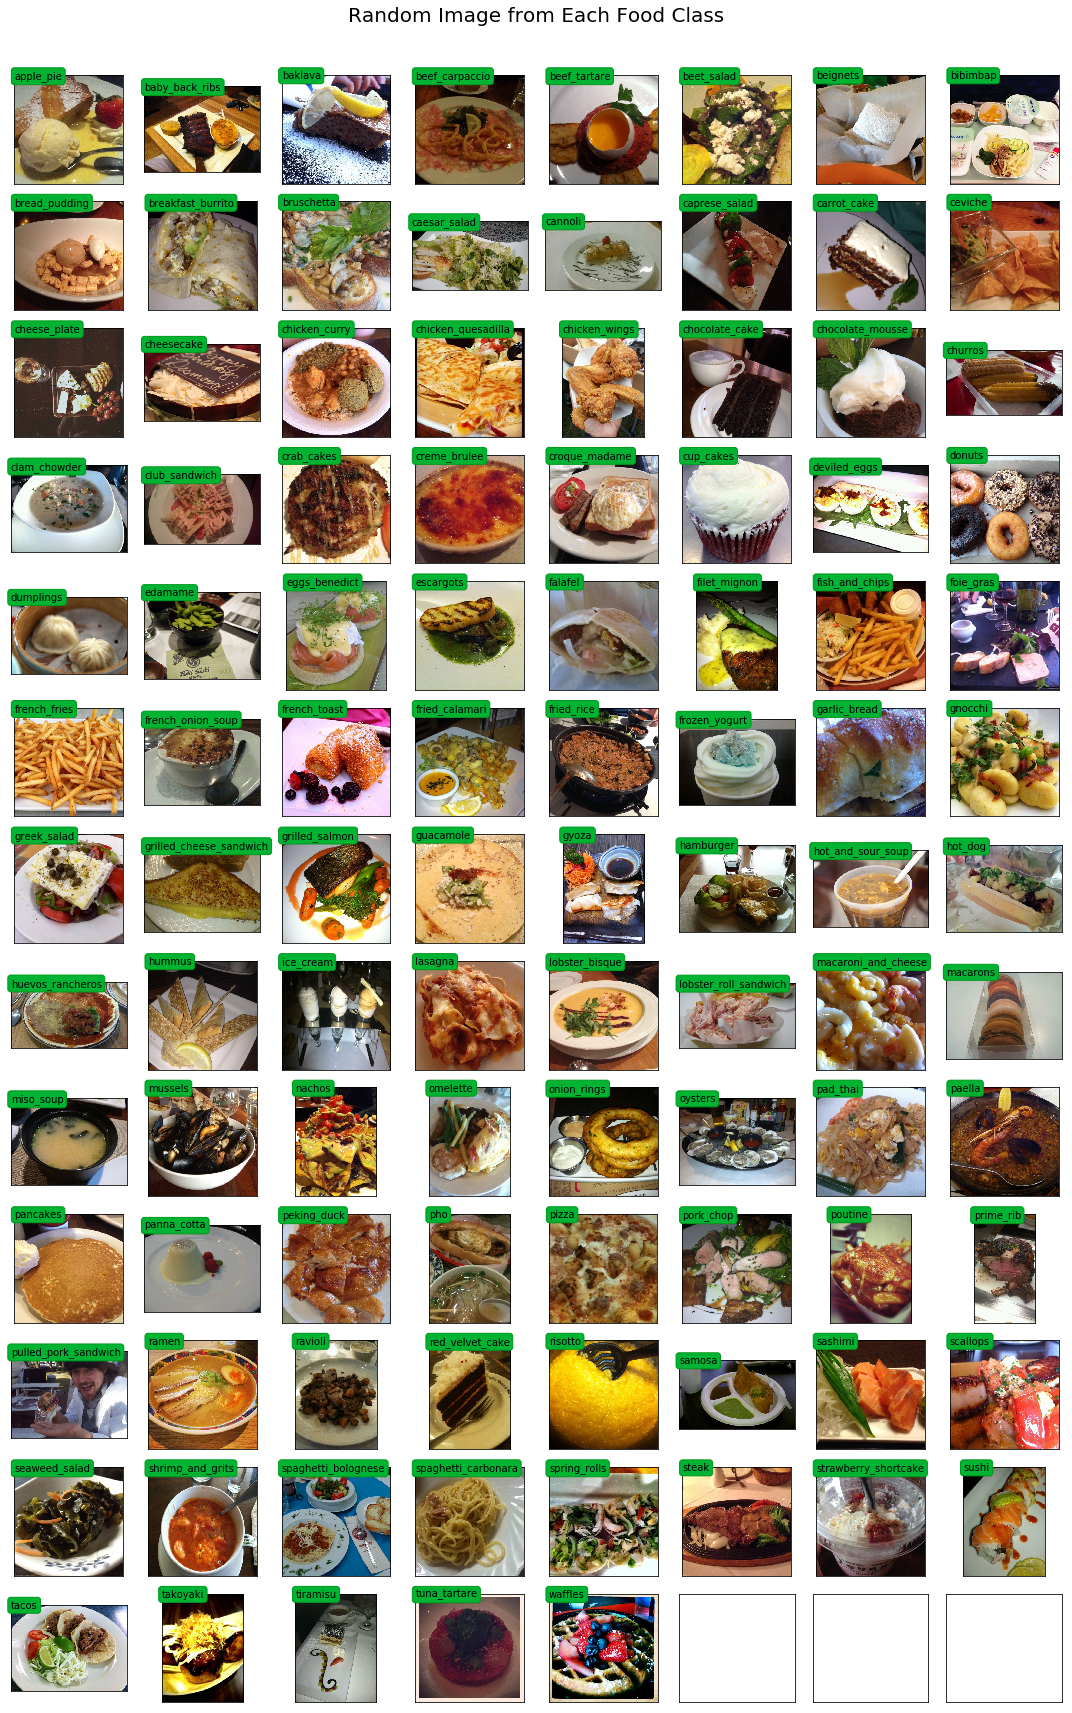

In [49]:
root_dir = 'food101/train_other/'
rows = 13
cols = 8
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [28]:
class_to_ix = {}
ix_to_class = {}
with open('food101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
keys = []
for key,value in class_to_ix.items():
    keys.append(key)
print(np.random.choice(keys, size=10,replace=True))

['sushi' 'greek_salad' 'mussels' 'paella' 'omelette' 'frozen_yogurt'
 'beef_tartare' 'caesar_salad' 'bibimbap' 'filet_mignon']


# Part 2 begin

In [1]:
import argparse
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pretrainedmodels
import pretrainedmodels.utils

model_names = sorted(name for name in pretrainedmodels.__dict__
                     if not name.startswith("__")
                     and name.islower()
                     and callable(pretrainedmodels.__dict__[name]))
print(model_names)

['alexnet', 'bninception', 'cafferesnet101', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'dpn107', 'dpn131', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'fbresnet152', 'inceptionresnetv2', 'inceptionv3', 'inceptionv4', 'nasnetalarge', 'nasnetamobile', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x4d', 'resnext101_64x4d', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'xception']


In [2]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda()
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg, top5.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [7]:
best_prec1 = 0

class parse_args:
    def __init__(self):
        self.data = "data/"
#         self.data = "food101/"
        self.arch = "resnet101"
        self.workers = 4
        self.epochs = 90
        self.start_epoch = 0
        self.batch_size = 10
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.evaluate = False
        self.pretrained = 'imagenet'
    
    
def main():
    global args, best_prec1
    args = parse_args()
    print("Now train the model on",args.arch)
    model = pretrainedmodels.__dict__[args.arch](num_classes=1000,pretrained=args.pretrained)
    features_size = model.last_linear.in_features
    model.last_linear = nn.Linear(features_size,10)
#     model.last_linear = nn.Linear(features_size,101)
    
#     # Data loading code
#     data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

#     data_dir = args.data
#     image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'test']}
#     dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'test']}
#     train_loader = dataloaders['train']
#     val_loader = dataloaders['test']


 # Data loading code
    traindir = os.path.join(args.data, 'train')
    valdir = os.path.join(args.data, 'test')

    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(traindir, transforms.Compose([
            transforms.RandomSizedCrop(max(model.input_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

    

    if 'scale' in pretrainedmodels.pretrained_settings[args.arch][args.pretrained]:
        scale = pretrainedmodels.pretrained_settings[args.arch][args.pretrained]['scale']
    else:
        scale = 0.875
    
    
    print('Images transformed from size {} to {}'.format(
        int(round(max(model.input_size) / scale)),
        model.input_size))
    

    
    val_tf = pretrainedmodels.utils.TransformImage(model, scale=scale)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, val_tf),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    
    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,momentum=args.momentum,weight_decay=args.weight_decay)

    model = torch.nn.DataParallel(model,device_ids=[0, 1, 2, 3, 4, 5, 6, 7])
    
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    if args.evaluate:
        validate(val_loader, model, criterion)
        return

    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)
main()

Now train the model on resnet101


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/luxiaohang/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:05<00:00, 34317445.37it/s]


Images transformed from size 256 to [3, 224, 224]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
